In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import mutual_info_score
#to ignore the "FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated;" 
#Google says it's a version problem, I have no idea, but Google tell me do add these 2 lines so I did
import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy.spatial.distance import pdist, squareform
def VAT(R):
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    
    I = i[j]
    del J[I]
    
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]

    for r in range(2, N-1):
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)
        y = np.min(y)
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])

    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)

    I.extend(J)
    C.extend(i)

    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    return RV.tolist(), C, I


def entropy(probs):
    
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 


In [3]:
food =  pd.read_csv("food_nutrient_2011_13_AHS.csv", header=0,low_memory=False)

In [4]:
##Question 1  Feature Standardisation

###1a
#pick all the continuous features from food and store in a new dataframe food_with_con
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
#transform all the data into the float type (cause there are some int type feature in the dataframe)
food_with_con = food_with_con.astype("float")

###1b
#normalise the data to have 0 mean and unit variance using the library functions. 
scaler = StandardScaler().fit(food_with_con)
foodscaled=scaler.transform(food_with_con)

#change the matrix into the dataframe form 
foodscaled = pd.DataFrame(foodscaled)


###1c
#find the number of rows and columns of the foodscaled
nRows = foodscaled.shape[0]
nCols = foodscaled.shape[1]

#find the minimum and maximum number in the foodscaled 
minValue = round(foodscaled.min().min(), 1)
maxValue = round(foodscaled.max().max(), 1)

#find the mean and standard deviation of the foodscaled 
meanValue = round(foodscaled.mean().mean(), 1)
stdValue = round(foodscaled.values.std(), 1)

#print all the result out 
print("***")
print("Q1.c:foodscaled matrix details")
print("Number of rows: "+str(nRows))
print("Number of columns: "+str(nCols))
print("Min: "+str(minValue))
print("Max: "+str(maxValue))
print("Mean: "+str(-meanValue)) # cause the float type problem, there is a negative sign before the mean value, so I just add a negative sign to make it more beautiful, it will not effect the result cause we normalize the mean value to 0.
print("Standard Deviation "+str(stdValue))
print("***")

***
Q1.c:foodscaled matrix details
Number of rows: 5740
Number of columns: 53
Min: -2.0
Max: 75.8
Mean: 0.0
Standard Deviation 1.0
***


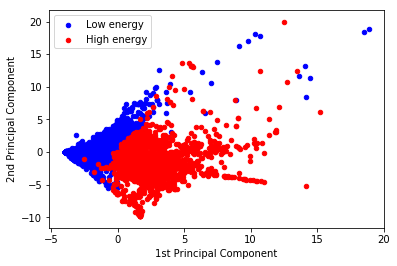

In [5]:
#Question 2 Principal Components Analysis
#reset the foodscaled at the beginning of the question. avoid some unexpected error
#comment of these code is at the question 1, I just copy these from question 1, nothing new
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
food_with_con = food_with_con.astype("float")
scaler = StandardScaler().fit(food_with_con)
foodscaled=scaler.transform(food_with_con)
foodscaled = pd.DataFrame(foodscaled)

###2a
#create the feature EnergyLevel which has value '1' if unstandardized Energy, with dietary fibre (kJ)is greater than 1000kj and '0' otherwise 
EnergyLevel= food['Energy, with dietary fibre (kJ)'].apply(lambda x: '1' if x > 1000 else '0')

###2b
#apply principal components analysis to foodscaled and set the number oc components equals to 2
pca=PCA(n_components=2)
#store the result in the foodreduced 
foodreduced=pca.fit_transform(foodscaled)
#transform the foodreduced into the dataframe form 
foodreduced= pd.DataFrame(foodreduced)
foodreduced.columns = ["1st Principal Component","2nd Principal Component"]

###2c
#add the feature EnergyLevel in the foodreduced to draw the scatter plot
foodreduced["EnergyLevel"] = EnergyLevel

#seperate that value into different color according to the energylevel
blueElement = foodreduced[foodreduced["EnergyLevel"]=='0']
redElement = foodreduced[foodreduced["EnergyLevel"]=='1']

#plot low energylevel scatter plot(with color blue) first and add another data(with color red) at the same plot
ax = blueElement.plot.scatter(x="1st Principal Component",y="2nd Principal Component", c='b', label='Low energy')
redElement.plot.scatter(x="1st Principal Component",y="2nd Principal Component",c='r', label = 'High energy', ax=ax)


Question 2d 

1) The scatter plot is a projection that captures the largest amount of nutrition variance of different food, (we also seperate different level energy food by different color). 

2) The nutrition variance of low_energy food is less than high_energy one. and there is a significant differece in the nutrient variance between low_energy food and high_energy food 

3) 
Advantage: The original food dataset has 53 features, it is hard to visualize. The PCA can make the dataset into a 2-dimensional dataset to give a clear sense of variance. 

Disadvantage: On the process of dimension reduction, Some data will inevitably be lost. (eg.we cannot know which attribute casuse the biggest difference in food.)


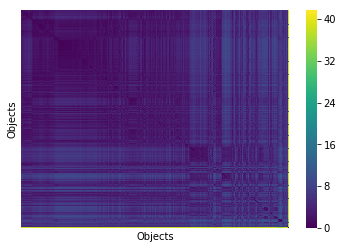

In [6]:
#Question 3
#reset the foodscaled at the beginning of the question, avoid unexpected error
#comment of these code is at the question 1, I just copy these from question 1, nothing new
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
food_with_con = food_with_con.astype("float")
scaler = StandardScaler().fit(food_with_con)
foodscaled=scaler.transform(food_with_con)
foodscaled = pd.DataFrame(foodscaled)


###3a
# Convert the datatype of the Survey ID attribute into the string type
food['Survey ID'] = food['Survey ID'].astype('str')

#create the new attribute according to the survey ID
foodCate = food['Survey ID'].str.slice(0, 2)


###3b
#insert the attribute into foodscaled
foodscaled["Food category"] = foodCate

#find the the food with Food Category equals 13, 20, 24. and combine them into a new dataframe called foodscaledsample
foodscaledsample = foodscaled.loc[foodscaled["Food category"].isin(["13","20","24"])]
#delete column "Food category" avoid it affecting the data
del foodscaledsample["Food category"]


###3c

#Apply VAT Algorithm to foodscaledsample dataset and visualise using heatmap
RV, C, I = VAT(foodscaledsample)
x=sns.heatmap(RV,cmap='viridis',xticklabels=False,yticklabels=False)
x.set(xlabel='Objects', ylabel='Objects')
plt.show()


Question 3e 

1) There are 2 clusters in this heatmap. 

2) This is not expected, because there are 3 food category(13, 20, 24) in the dataset. 

3) When two of the food category are very close together and some heatmap colors will make them seems like there is  only one food category.

4) One category's color is well separated from other two, and the two similar food category's colors is similar but still can tell they are different. (The greater the color difference, the better)

5) Just some result after some experiments: 

I tried to add "food category" in the foodscaled, that shows me 2 obvious clusters or (3 cluster which is not so obvious). That shows the data is very close with each other, so that they will been effect so obvious by a discrete attribute(which is also being proved by question4). 

And I tried these 3 category one-to-one, and found there is nearly no difference betweem 20 and 24 food category. So they are the pair very close to each other. 

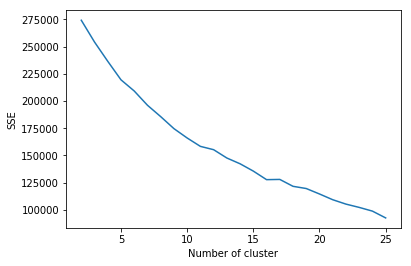

In [7]:
#Question 4
#reset the foodscaled at the beginning of the question. avoid some unexpected error
#comment of these code is at the question 1, I just copy these from question 1, nothing new
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
food_with_con = food_with_con.astype("float")
scaler = StandardScaler().fit(food_with_con)
foodscaled=scaler.transform(food_with_con)
foodscaled = pd.DataFrame(foodscaled)

#create a dictionary that will store number Of clusters and cooresponding SSE
sse = {}

#set the number of k from 2 to 25
for k in range(2, 26):
    #find the kmeans 
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(foodscaled)
    #and calculate the certain SSE
    # Inertia: Sum of distances of samples to their closest cluste(definition in document)
    # SSE(sum of squared errors): Sum of distances of objects from their cluster centroids(definition in workshop6 question5)
    #they should be the same thing
    sse[k] = kmeans.inertia_  

#plot the sse out 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Question 4b

Shape:

The graph is a decreasing line.(nearly a linear decreasing line)


Elbow:

There is no "obvious" elbow in this graph, and every time I run my code, the small elbow will appear at different value(k-mean is random). While I found elbow at numOfCluster = 18 or numOfCluster = 19 is pretty stable.


Analysis:

This shape is expected cause as the cluster increase, the distance from each point to its cluster center will be decrese. so the shape should be decreasing. 

And for the elbow, There are 22 food category and there are the nutrition variance of some food category are close to each other so the elbow should exist between 15 to 22.

At the same time there's no "obvious" elbow in the graph shows that these data are distributed evenly.

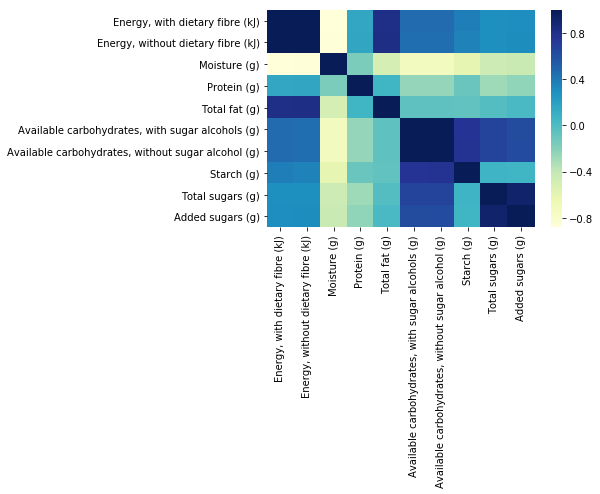

In [8]:
###Question 5

###5a
# find out the corresponding features 
food_corr = food.loc[:,'Energy, with dietary fibre (kJ)':'Added sugars (g)']
#calculate their pearson correlation
correlationDF = food_corr.corr(method='pearson')

#use heatmap to plot the matrix 
ax=sns.heatmap(correlationDF,cmap='YlGnBu')
plt.show()

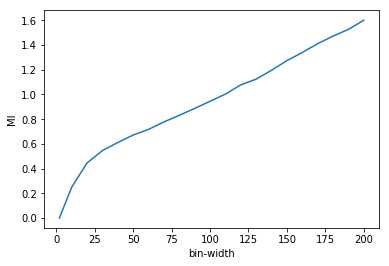

In [9]:
#5b
#take the attribute 'Energy, with dietary fibre (kJ)' and 'Protein (g)' out. 
Energy = food['Energy, with dietary fibre (kJ)']
Protein = food['Protein (g)']

#create a dictionary that will store bin-width and cooresponding Mutual Information
MI = {}


#use the cut function to cassify the data with bin-width = 2
cuttedEnergy = pd.cut(Energy, 2, labels=False)
cuttedProtein = pd.cut(Protein, 2, labels=False)
#use the provided MI function to find the mutual information
currentDataFrame = pd.DataFrame({'Energy':cuttedEnergy, 'Protein':cuttedProtein})
result = mutual_info(currentDataFrame)
#store the result in the MI dictionary
MI[2] = result.get("MI")


#set the number of l from 10 to 200
for l in range(10, 210, 10):
    #use the cut function to cassify the data with certain bin-width
    cuttedEnergy = pd.cut(Energy, l, labels=False)
    cuttedProtein = pd.cut(Protein, l, labels=False)
    currentDataFrame = pd.DataFrame({'Energy':cuttedEnergy, 'Protein':cuttedProtein})
    #use the provided MI function to find the mutual information
    result = mutual_info(currentDataFrame)
    #store the result in the MI dictionary
    MI[l] = result.get("MI")
    
#plot the MI out
plt.figure()
plt.plot(list(MI.keys()), list(MI.values()))
plt.xlabel("bin-width")
plt.ylabel("MI")
plt.show()    
    

##### Question 5b 

It is a increasing trend, the MI value increasing slowly before bin-width = 20. becomes a linear increasing line after bin-width=20.

The formula for mutual information: MI(MI(X, Y) = H(X)-H(X|y).H(X) evaluate the entropy of X, and as the bin-width increase, the distribution of the values will be more uniform, so that the entropy value of X will be increase. So as the bin-width increase, we can see more clear that how X and Y are related. 


In [10]:
###5c 

#Pearson correlation 

#pick all the continuous features from food and store in a new dataframe food_with_con
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
#transform all the data into the float type (cause there are some int type feature in the dataframe)
food_with_con = food_with_con.astype("float")

#calculate 53 pairs of Pearson correlation
correlationDF = food_with_con.corr(method='pearson')
#change all values on the diagonal to zero 
correlationDF.values[[np.arange(len(correlationDF.index))]*2] = 0
#find the top 10 feature-pairs 
sortedCorrelation = correlationDF.max().sort_values(ascending = False)



#store the feature and Pearson value in the TopPearsonCor dataframe
#feature1 is the one of the feature pair and feature 2 is another
feature1 = []
feature2 = []
# Pearson_value is the Pearson correlation Pearson value corresponding to the feature1 and feature2
Pearson_Value = []

#cause the series has already sorted, so we only need to find top 10 by the order of the series 
for index in sortedCorrelation.index:
    # when there are already 10 values, then stop the loop
    if(len(Pearson_Value)==10):
        break
        
    #when there are no value in the list or this value is not repeated value of last pair(feature1 VS feature2 and feature2 VS feature1 are repeated)
    if(len(Pearson_Value)==0 or sortedCorrelation[index]!=Pearson_Value[-1]):
        #store the features and Pearson correlation value into the list
        feature1.append(index)
        Pearson_Value.append(sortedCorrelation[index])
        corfeature = correlationDF[correlationDF[index]==sortedCorrelation[index]].index.tolist()[0]
        feature2.append(corfeature)
        
#store all these information together 
data = {"feature1":feature1, "feature2":feature2, "Pearson Value":Pearson_Value}
ToptenPearsoncor = pd.DataFrame(data)
newIndex = list(range(1, 11))
ToptenPearsoncor.index  = newIndex
#print the dataframe out
ToptenPearsoncor


,feature1,feature2,Pearson Value
1,Alpha-tocopherol (mg),Vitamin E (mg),0.999528
2,"Energy, with dietary fibre (kJ)","Energy, without dietary fibre (kJ)",0.998608
3,Beta-carotene (µg),Provitamin A (b-carotene equivalents) (µg),0.995961
4,"Available carbohydrates, with sugar alcohols (g)","Available carbohydrates, without sugar alcohol...",0.995466
5,Free sugars (g),Added sugars (g),0.988894
6,Total Folates (µg),Dietary folate equivalents (µg),0.985763
7,Total polyunsaturated fat (g),Linoleic acid (g),0.973640
8,Folic acid (µg),Dietary folate equivalents (µg),0.958112
9,Preformed vitamin A (retinol) (µg),Vitamin A retinol equivalents (µg),0.954100
10,C22:6w3 Docosahexaenoic (mg),Total long chain omega 3 fatty acids (mg),0.952762


In [11]:
#Mutual Information
#pick all the continuous features from food and store in a new dataframe food_with_con
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
#transform all the data into the float type (cause there are some int type feature in the dataframe)
food_with_con = food_with_con.astype("float")

#create empty cloumn feature pair and Mutual Information for the dataframe 
#attribute1 is the one of the feature pair and attribute 2 is another
attribute1 =[]
attribute2 =[]
#Mutual_information is the corresponding MI for the certain pairs
Mutual_information = []

# go through every pair in the continuous features
for index1 in food_with_con.columns:
    for index2 in food_with_con.columns:
        if index1==index2:
            pass
        else:
            #store the certain feature name in the attributes list 
            attribute1.append(index1)
            attribute2.append(index2)
            
            #find the Mutual information by the MI function with bin-width 20
            feature1= food_with_con[index1]
            feature2= food_with_con[index2]
            cuttedfeature1 = pd.cut(feature1, 20, labels=False)
            cuttedfeature2 = pd.cut(feature2, 20, labels=False)
            currentDataFrame = pd.DataFrame({'feature1':cuttedfeature1, 'Protein':cuttedfeature2})
            result = mutual_info(currentDataFrame)
            #store the result in the MI list 
            Mutual_information.append(result["MI"])
            
#store all the information together as a dataframe
data = {"feature1":attribute1, "feature2":attribute2, "Mutual information":Mutual_information}
MIlist = pd.DataFrame(data)
#sort the dataframe by the value of mutual information 
sortedMI = MIlist.sort_values(by="Mutual information", ascending = False)    

# then find the top 10 MI value 
toptenMI = sortedMI.iloc[0:20, :]
newIndex = list(range(0, 20))
toptenMI.index  = newIndex
for i in range(0, 20):
    if(i%2 == 1):
        toptenMI = toptenMI.drop(i)
newIndex = list(range(1, 11))
toptenMI.index  = newIndex


# print the top ten pairs out
toptenMI

,feature1,feature2,Mutual information
1,"Energy, with dietary fibre (kJ)","Energy, without dietary fibre (kJ)",3.140250
2,"Available carbohydrates, with sugar alcohols (g)","Available carbohydrates, without sugar alcohol...",3.070813
3,"Energy, with dietary fibre (kJ)",Moisture (g),1.880160
4,"Energy, without dietary fibre (kJ)",Moisture (g),1.791029
5,Tryptophan (mg),Protein (g),1.359985
6,Free sugars (g),Added sugars (g),1.253871
7,Starch (g),"Available carbohydrates, without sugar alcohol...",1.101232
8,Starch (g),"Available carbohydrates, with sugar alcohols (g)",1.095449
9,Free sugars (g),Total sugars (g),0.978975
10,"Energy, with dietary fibre (kJ)",Total fat (g),0.959014


Question 5c 


There are some top10 feature-pairs by Pearson occur in the top 10 feature_pairs by Mutual Information.

Pearson value is for assessing linear correlation, the top 10 feature-pairs by Pearson are the top 10 feature-pairs has most strong linear correlation. 

And Mutual Information is a measure of correlation the amount of information about one attribute we gain by another.

So the linear correlation can also being measure by Mutual Information but not as accurate as Pearson.

That's why some of top10 feature-pairs by Pearson occur in the top 10 feature_pairs by Mutual Information. 

And other top 10 feature_pairs by Mutual Information(that is not in Pearson) are the ones got other 
correlation(eg.quadratic correlation) that is not defect by the Pearson

***
X_train matrix:  (4592, 53)
y_train labels:  (4592, 1)
X_test matrix:  (1148, 53)
y_test labels:  (1148, 1)
***


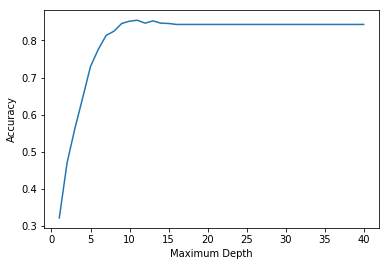

In [13]:
##Question 6
#reset the foodscaled at the beginning of the question
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
food_with_con = food_with_con.astype("float")
scaler = StandardScaler().fit(food_with_con)
foodscaled=scaler.transform(food_with_con)
foodscaled = pd.DataFrame(foodscaled)

#reset the food category attribute
food['Survey ID'] = food['Survey ID'].astype('str')
foodCate = food['Survey ID'].str.slice(0, 2)

###6a
#randomly select 80% of instances to be training and the rest to be testing 
X_train, X_test, y_train, y_test = train_test_split(foodscaled, foodCate,train_size=0.80, test_size=0.20, random_state=0)

#cause there is only 1 attribute in the y_train and y_test, so ther is no values on shape[1], so we add 1 manully
y_train_tuple = (y_train.shape[0], 1)
y_test_tuple = (y_test.shape[0], 1)

#print out all the result 
print("***")
print("X_train matrix: ", str(X_train.shape))
print("y_train labels: ", str(y_train_tuple))
print("X_test matrix: ", str(X_test.shape))
print("y_test labels: ", str(y_test_tuple))
print("***")


###6b
# create a dictionary to 
accuracy = {}
for k in range(1, 41):
    #train the decision tree by useing training data, and set the max_depth as k
    clf = DecisionTreeClassifier(criterion = "entropy", random_state= 1, max_depth=k)
    clf.fit(X_train, y_train)
    #calculate the accuracy score for using on the testing data
    y_pred = clf.predict(X_test)
    accuracy[k] = accuracy_score(y_test, y_pred)

#Plot the accuracy dictionary out     
plt.figure()
plt.plot(list(accuracy.keys()), list(accuracy.values()))
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.show()


Question 6c 
The shape of the graph shows that 

      accuracy increase rapidly as the maximum-depth increase, 0 <= maximum-depth <= 12
      
      accuracy reach its maximum value 0.85 , maximum-depth = 11
      
      accuracy drop a little bit and become and constant value , maximum-depth > 11

max-depth is how depth that allow the tree to grow to, and at the same time the model will be more complex. It will much fitter the training data, so that the accuracy will increase. this is why graph act like this at the beginning. As max-depth continue increasing, There are not so many features affect the result, so the change of accuracy becomes small and tend to be a specific value.

"If set max_depth too high, then the decision tree might simply overfit the training data without capturing useful patterns as we would like; this will cause testing error to increase.while if set it too low, that is not good as well" (quote from https://stackoverflow.com/questions/49289187/decision-tree-sklearn-depth-of-tree-and-accuracy). According to our graph,  maximum-depth = 11 is the best choice.

In [14]:
#Question 7

#reset the foodscaled at the beginning of the question
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
food_with_con = food_with_con.astype("float")
scaler = StandardScaler().fit(food_with_con)
foodscaled=scaler.transform(food_with_con)
foodscaled = pd.DataFrame(foodscaled)

#reset the food category attribute
food['Survey ID'] = food['Survey ID'].astype('str')
foodCate = food['Survey ID'].str.slice(0, 2)

###7a

#randomly select 80% of instances to be training and the rest to be testing 
X_train, X_test, y_train, y_test = train_test_split(foodscaled, foodCate, test_size=0.2)

# using the training data to predict the result by 1-neighbur-classifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train) 

#calculate the accuracy for both training data and testing data 
acc1 = neigh.score(X_train, y_train) 
acc2 = neigh.score(X_test, y_test) 

#print the result out 
print("***")
print("Q7a: Food category prediction using k-NN(k=1)")
print("Train accuracy: "+str(round(acc1*100, 1))+"%")
print("Test accuracy: "+str(round(acc2*100, 1))+"%")
print("***")



##7b
#randomly select 80% of instances to be training and the rest to be testing 
X_train, X_test, y_train, y_test = train_test_split(foodscaled, foodCate, test_size=0.2, random_state=42)

# using the training data to predict the result by 3-neighbur-classifier
neigh2 = KNeighborsClassifier(n_neighbors=3)
neigh2.fit(X_train, y_train) 

#calculate the accuracy for both training data and testing data
acc1 = neigh2.score(X_train, y_train) 
acc2 = neigh2.score(X_test, y_test) 

#print the result out 
print("***")
print("Q7b: Food category prediction using k-NN(k=3)")
print("Train accuracy: "+str(round(acc1*100, 1))+"%")
print("Test accuracy: "+str(round(acc2*100, 1))+"%")
print("***")


***
Q7a: Food category prediction using k-NN(k=1)
Train accuracy: 100.0%
Test accuracy: 89.5%
***
***
Q7b: Food category prediction using k-NN(k=3)
Train accuracy: 93.3%
Test accuracy: 88.0%
***


Question 7c 

Similarity:

1) The test accuracy is pretty similar for k=1 and k=3 

2) The training accuracy is always higher than the testing accuracy 

Difference:

1) The train accuracy for k=1 and k=3 is different

Analysis: 

For k=1, the data is trained with its nearest point, so its accuracy should be 100%, (just like what it being trained use into the test, they are the same thing). while for k=3, the data's uncertainty increase, so even for the training data itselt, the accuracy is decreased.   


Question 7d 

The accurancy would be biased, since the testing data was looked at when doing feature selection process that should not have been seen. Consequenctly the model that was trained using the results from the feature selection was developed on information that should not have been seen. The accuracy will thus likely be over optimistic 


# Question 8

# The Interaction Term  Pairs Parts 

In [15]:
#First Method to generate the generate the new feature
#Interaction term pairs
#fpair = f1*f2
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
food_with_con = food_with_con.astype("float")
scaler = StandardScaler().fit(food_with_con)
foodscaled=scaler.transform(food_with_con)
foodscaled = pd.DataFrame(foodscaled)

# for features in foodscaled.columns:
#     print(foodscaled[features])

foodscaled
for i in range(53):
    for j in range(i, 53):
        if i == j:
            pass
        else:
            newfeatureName ="" + str(i)+ "*" + str(j)
            foodscaled[newfeatureName] = foodscaled[i]*foodscaled[j]
foodwithmul = foodscaled


In [16]:
#calculate the MI for foodwithmul
food['Survey ID'] = food['Survey ID'].astype('str')
foodCate = food['Survey ID'].str.slice(0, 2)
foodCate = foodCate.astype('int')
attribute1 =[]
Mutual_information = []

cuttedfeature2 = pd.cut(foodCate, 20, labels=False)

for index1 in foodwithmul.columns:

    attribute1.append(index1)
            
    feature1= foodwithmul[index1]
    
    cuttedfeature1 = pd.cut(feature1, 20, labels=False)

    currentDataFrame = pd.DataFrame({'feature1':cuttedfeature1, 'Food category':cuttedfeature2})
    
    result = mutual_info(currentDataFrame)
    
    Mutual_information.append(result["MI"])
            
data = {"feature1":attribute1,"Mutual information":Mutual_information}
MIlist = pd.DataFrame(data)

sortedMI = MIlist.sort_values(by="Mutual information", ascending = False)       

newIndex = list(range(sortedMI.shape[0]))
sortedMI.index  = newIndex



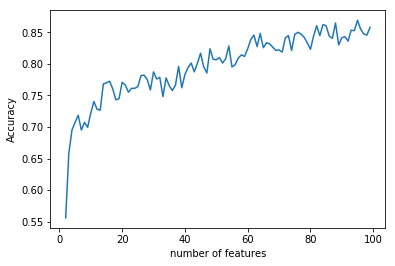

In [17]:
#select the different numbers of features
food['Survey ID'] = food['Survey ID'].astype('str')
foodCate = food['Survey ID'].str.slice(0, 2)

mulaccuracy = {}
for n in range(2, 100):
    data = pd.DataFrame(columns=())
    features = sortedMI.loc[0:n,["feature1"]]
    for i in features.values:
        data[i] = foodwithmul[i]

    X_train, X_test, y_train, y_test = train_test_split(data,foodCate,test_size=0.2)
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train, y_train) 
    acc2 = neigh.score(X_test, y_test) 
    mulaccuracy[n] = acc2

#plot the result
plt.figure()
plt.plot(list(mulaccuracy.keys()), list(mulaccuracy.values()))
plt.xlabel("number of features")
plt.ylabel("Accuracy")
plt.show()

In [18]:
#First Method to generate the generate the new feature
#Interaction term pairs
#fpair = f1/f2
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
food_with_con = food_with_con.astype("float")
scaler = StandardScaler().fit(food_with_con)
foodscaled=scaler.transform(food_with_con)
foodscaled = pd.DataFrame(foodscaled)

# for features in foodscaled.columns:
#     print(foodscaled[features])

foodscaled
for i in range(53):
    for j in range(i, 53):
        if i == j:
            pass
        else:
            newfeatureName ="" + str(i)+ "/" + str(j)
            foodscaled[newfeatureName] = foodscaled[i]/foodscaled[j]
foodwithfract = foodscaled  

In [19]:
#calculate the MI for foodwithfract
food['Survey ID'] = food['Survey ID'].astype('str')
foodCate = food['Survey ID'].str.slice(0, 2)
foodCate = foodCate.astype('int')
attribute1 =[]
Mutual_information = []

cuttedfeature2 = pd.cut(foodCate, 20, labels=False)

for index1 in foodwithfract.columns:

    attribute1.append(index1)
            
    feature1= foodwithfract[index1]
    
    cuttedfeature1 = pd.cut(feature1, 20, labels=False)

    currentDataFrame = pd.DataFrame({'feature1':cuttedfeature1, 'Food category':cuttedfeature2})
    
    result = mutual_info(currentDataFrame)
    
    Mutual_information.append(result["MI"])
            
data = {"feature1":attribute1,"Mutual information":Mutual_information}
MIlist = pd.DataFrame(data)

sortedMI = MIlist.sort_values(by="Mutual information", ascending = False)       

newIndex = list(range(sortedMI.shape[0]))
sortedMI.index  = newIndex

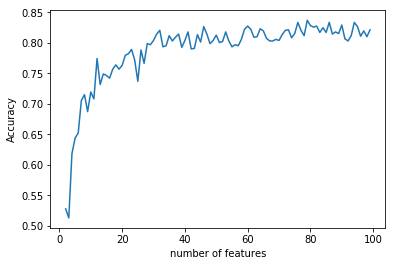

In [20]:
#select the different numbers of features
food['Survey ID'] = food['Survey ID'].astype('str')
foodCate = food['Survey ID'].str.slice(0, 2)


fracaccuracy = {}
for n in range(2, 100):
    data = pd.DataFrame(columns=())
    features = sortedMI.loc[0:n,["feature1"]]
    for i in features.values:
        data[i] = foodwithfract[i]

    X_train, X_test, y_train, y_test = train_test_split(data,foodCate,test_size=0.2)
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train, y_train) 
    acc2 = neigh.score(X_test, y_test) 
    fracaccuracy[n] = acc2

#plot the result
plt.figure()
plt.plot(list(fracaccuracy.keys()), list(fracaccuracy.values()))
plt.xlabel("number of features")
plt.ylabel("Accuracy")
plt.show()

# The Clustering Labels Parts

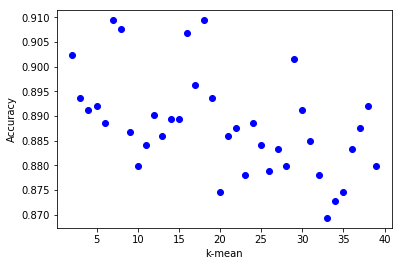

In [21]:
#######################################################

food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
food_with_con = food_with_con.astype("float")
scaler = StandardScaler().fit(food_with_con)
foodscaled=scaler.transform(food_with_con)
foodscaled = pd.DataFrame(foodscaled)

food['Survey ID'] = food['Survey ID'].astype('str')
foodCate = food['Survey ID'].str.slice(0, 2)

kaccuracy = {}
for k in range(2, 40):
    #generates the cluster labels with certain k
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(foodscaled)
    labels= kmeans.labels_
    labels = pd.Series(labels)
    labels.value_counts()
    #add the generated attributes in the dataframe
    foodscaled["clusterlabel"] = labels
    foodwithcluster = foodscaled
    
    #use the new dataframe to do the prediction 
    #randomly select 80% of instances to be training and the rest to be testing 
    X_train, X_test, y_train, y_test = train_test_split(foodwithcluster , foodCate, test_size=0.2)
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train, y_train) 
    acc2 = neigh.score(X_test, y_test) 
    kaccuracy[k] = acc2

#plot the graph out 
plt.figure()
plt.plot(list(kaccuracy.keys()), list(kaccuracy.values()), "bo")
plt.xlabel("k-mean")
plt.ylabel("Accuracy")
plt.show()




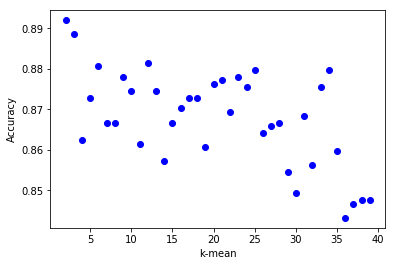

In [22]:
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
food_with_con = food_with_con.astype("float")
scaler = StandardScaler().fit(food_with_con)
foodscaled=scaler.transform(food_with_con)
foodscaled = pd.DataFrame(foodscaled)

food['Survey ID'] = food['Survey ID'].astype('str')
foodCate = food['Survey ID'].str.slice(0, 2)

kaccuracy = {}
for k in range(2, 40):
    #generates the cluster labels with certain k
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(foodscaled)
    labels= kmeans.labels_
    labels = pd.Series(labels)
    labels.value_counts()
    #add the generated attributes in the dataframe
    foodscaled["clusterlabel"] = labels
    foodwithcluster = foodscaled
    
    #use the new dataframe to do the prediction 
    #randomly select 80% of instances to be training and the rest to be testing 
    X_train, X_test, y_train, y_test = train_test_split(foodwithcluster , foodCate, test_size=0.2)
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train, y_train) 
    acc2 = neigh.score(X_test, y_test) 
    kaccuracy[k] = acc2

#plot the graph out 
plt.figure()
plt.plot(list(kaccuracy.keys()), list(kaccuracy.values()), "bo")
plt.xlabel("k-mean")
plt.ylabel("Accuracy")
plt.show()

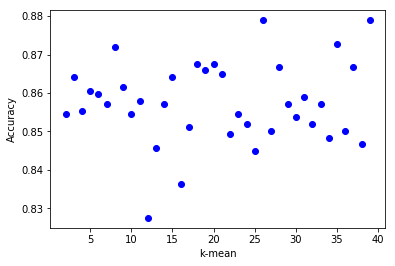

In [23]:
food_with_con = food.loc[:,'Energy, with dietary fibre (kJ)':'Total trans fatty acids (mg)']
food_with_con = food_with_con.astype("float")
scaler = StandardScaler().fit(food_with_con)
foodscaled=scaler.transform(food_with_con)
foodscaled = pd.DataFrame(foodscaled)

food['Survey ID'] = food['Survey ID'].astype('str')
foodCate = food['Survey ID'].str.slice(0, 2)

kaccuracy = {}
for k in range(2, 40):
    #generates the cluster labels with certain k
    kmeans = KMeans(n_clusters=k, max_iter=100).fit(foodscaled)
    labels= kmeans.labels_
    labels = pd.Series(labels)
    labels.value_counts()
    #add the generated attributes in the dataframe
    foodscaled["clusterlabel"] = labels
    foodwithcluster = foodscaled
    
    #use the new dataframe to do the prediction 
    #randomly select 80% of instances to be training and the rest to be testing 
    X_train, X_test, y_train, y_test = train_test_split(foodwithcluster , foodCate, test_size=0.2)
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X_train, y_train) 
    acc2 = neigh.score(X_test, y_test) 
    kaccuracy[k] = acc2

#plot the graph out 
plt.figure()
plt.plot(list(kaccuracy.keys()), list(kaccuracy.values()), "bo")
plt.xlabel("k-mean")
plt.ylabel("Accuracy")
plt.show()

# Comment for question 8

Question 8 

comments for the Interation term pairs

For both fpair = f1*f2 and fpair = f1/f2, the accuracy is similar, and it seems it cannot deliver an accuracy. But more MI-high feature we select the more accuracy the result get. 

comments for the clustering labels part

The clustering labels method can deliver an accuracy boost. But it only contribute to K-NN when k = 1 but not for higher k values

When we didn't generate new features, the accuracy has already being very high for the foodscaled and food category, so the contribute for the generate the new features seems not so obvious in this condition.